## Bruno Carrillo
### MCS 481 Project 3
### Voronoi-Based Motion Planning Analysis

### Problem Statement

The goal of this project was to explore the use of Voronoi diagrams in planned robotic motion. The nature of Voronoi diagrams makes it so that a path created by them would be a path maximizing space between the obstacles. I wanted to see what would happen to the runtime of generating and running Djikstra's algorithm on a Voronoi diagram of a floor plan with obstacles randomly generated when we increase the number and complexity of obstacles, when we slightly perturb the obstacles, and the difference between runtimes when using the vertices of the obstacles versus using sampled edges to generate the Voronoi Diagram

#### Setup and Imports

Before running the experiments, make sure to run each cell of code up until the cell labelled "Running Experiments"

In [19]:
import numpy as np
import random
from shapely.geometry import Polygon, LineString, Point
from shapely.affinity import translate
from shapely.ops import unary_union
from scipy.spatial import Voronoi
import time
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from matplotlib.collections import LineCollection

In [2]:
def build_graph(edges):
    "Builds graph to use Dijkstra"
    G = nx.Graph()
    for p1, p2 in edges:
        dist = np.linalg.norm(np.array(p1) - np.array(p2))
        G.add_edge(tuple(p1), tuple(p2), weight=dist)
    return G

def find_nearest_node(G, point):
    return min(G.nodes, key=lambda n: np.linalg.norm(np.array(point) - np.array(n)))

def run_dijkstra(G, start_pt, goal_pt):
    "Try to run Dijkstra. As obstacle count increases, the chance of no path existing also increases"
    try:
        start_node = find_nearest_node(G, start_pt)
        goal_node = find_nearest_node(G, goal_pt)
        start = time.time()
        path = nx.dijkstra_path(G, start_node, goal_node, weight='weight')
        total_time = time.time() - start
        return path, total_time
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return None, None

### Inital Setup

This section is to show the output of the functions and testing the time taken to generate Voronoi diagrams both from the vertices and edges of the obstacles.

#### Setting up the environment

In [3]:
def generate_random_polygon(center, radius=1.0, n_vertices=6):
    "Generates a random polygon"
    angles = sorted(random.uniform(0, 2*np.pi) for _ in range(n_vertices))
    points = [
        (center[0] + radius*np.cos(a), center[1] + radius*np.sin(a))
        for a in angles
    ]
    return Polygon(points).convex_hull

def generate_environment(n_obstacles, complexity=6, max_attempts=500, buffer=0.1):
    "Sets up the environment with the randomly generated obstacles"
    obstacles = []
    attempts = 0

    while len(obstacles) < n_obstacles and attempts < max_attempts:
        angle_step = 2 * np.pi / complexity
        radius = np.random.uniform(0.3, 0.6)
        jitter = np.random.uniform(0.05, 0.15, size=complexity)
        
        coords = [
            (
                (radius + jitter[i]) * np.cos(i * angle_step),
                (radius + jitter[i]) * np.sin(i * angle_step)
            )
            for i in range(complexity)
        ]
        new_poly = Polygon(coords)

        tx, ty = np.random.uniform(0.5, 9.5), np.random.uniform(0.5, 9.5)
        new_poly = translate(new_poly, xoff=tx, yoff=ty)
        
        intersects = any(new_poly.buffer(buffer).intersects(obs) for obs in obstacles)
        
        if not intersects and new_poly.within(Polygon([(0, 0), (0, 10), (10, 10), (10, 0)])):
            obstacles.append(new_poly)
        attempts += 1

    if len(obstacles) < n_obstacles:
        print(f"⚠️ Only placed {len(obstacles)} out of {n_obstacles} obstacles after {attempts} attempts.")

    return obstacles

def perturb_obstacles(obstacles, magnitude=1.0):
    "Slightly perturbs the obstacles"
    perturbed = []
    for poly in obstacles:
        new_coords = []
        for x, y in poly.exterior.coords[:-1]:
            dx, dy = np.random.uniform(-magnitude, magnitude, 2)
            new_coords.append((x+dx, y+dy))
        perturbed.append(Polygon(new_coords).convex_hull)
    return perturbed

#### Building the Voronoi Diagrams

In [4]:
def extract_vertices(obstacles):
    "Extracts vertices from the list of obstacles"
    points=[]
    for poly in obstacles:
        points.extend(poly.exterior.coords[:-1])
    return np.array(points)

def sample_edges(obstacles, num_samples_per_edge=3):
    "Takes a sample of the edges of the obstacles"
    sampled=[]
    for poly in obstacles:
        coords = list(poly.exterior.coords)
        for i in range(len(coords) -1):
            p1 = np.array(coords[i])
            p2 = np.array(coords[i+1])
            for t in np.linspace(0, 1, num_samples_per_edge):
                sampled.append((1-t) * p1 + t * p2)
    return np.array(sampled)

def compute_voronoi(points):
    "Computes the Voronoi diagram"
    return Voronoi(points)

def filter_edges(vor, obstacles):
    valid_edges=[]
    obs_union = unary_union(obstacles)
    for (p1, p2) in vor.ridge_vertices:
        if p1 == -1 or p2 == -1:
            continue
        a = vor.vertices[p1]
        b = vor.vertices[p2]
        edge = LineString([a,b])
        if not edge.crosses(obs_union) and obs_union.contains(Point(a)) == False and obs_union.contains(Point(b)) == False:
            valid_edges.append((a,b))
    return valid_edges

#### Visualizing

In [5]:
def plot_environment(obstacles, voronoi_edges=None, title="Voronoi Roadmap"):
    "Creates a plot to display the environment"
    fig, ax = plt.subplots()
    for poly in obstacles:
        xs, ys = poly.exterior.xy
        ax.fill(xs, ys, alpha=0.4, fc='gray', ec='black')

    if voronoi_edges:
        for (a,b) in voronoi_edges:
            ax.plot([a[0], b[0]], [a[1], b[1]], 'b--', linewidth=1)

    ax.set_aspect('equal')
    ax.set_title(title)
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.grid(True)
    plt.show()

#### Generate Obstacles

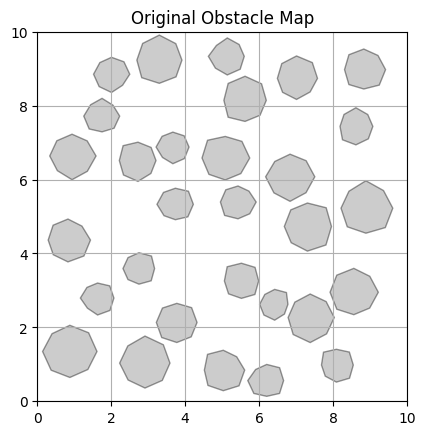

In [42]:
# Generating an environment with an arbitrary amount of obstacles
n_obstacles = 30
complexity = 8
obstacles = generate_environment(n_obstacles, complexity)
plot_environment(obstacles, title="Original Obstacle Map")

#### Compute Voronoi (Vertices)

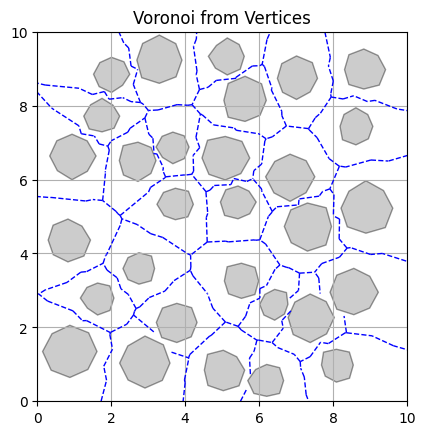

Time: 1.0504 sec, Edges: 289


In [43]:
# Showing the Voronoi diagram made by using obstacle vertices
vertex_points = extract_vertices(obstacles)
start = time.time()
vor = compute_voronoi(vertex_points)
edges_vtx = filter_edges(vor, obstacles)
total_time_vtx = time.time() - start
plot_environment(obstacles, edges_vtx, title="Voronoi from Vertices")
print(f"Time: {total_time_vtx:.4f} sec, Edges: {len(edges_vtx)}")

#### Compute Voronoi (Sampled Edges)

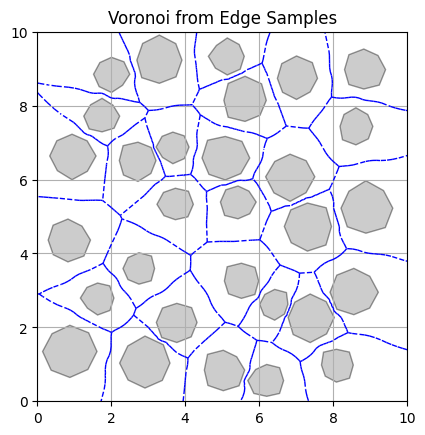

Time: 3.8274 sec, Edges: 1001


In [44]:
# Showing the Voronoi diagram made by using obstacle edges
edge_points = sample_edges(obstacles, 5)
start = time.time()
vor = compute_voronoi(edge_points)
edges_smpl = filter_edges(vor, obstacles)
total_time = time.time() - start
plot_environment(obstacles, edges_smpl, title="Voronoi from Edge Samples")
print(f"Time: {total_time:.4f} sec, Edges: {len(edges_smpl)}")

#### Perturbed Sensitivity Test

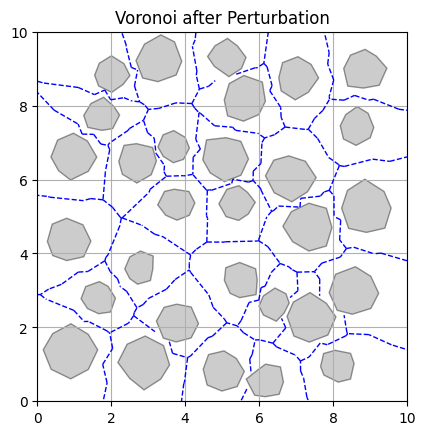

Time: 1.1225 sec, Edges: 283


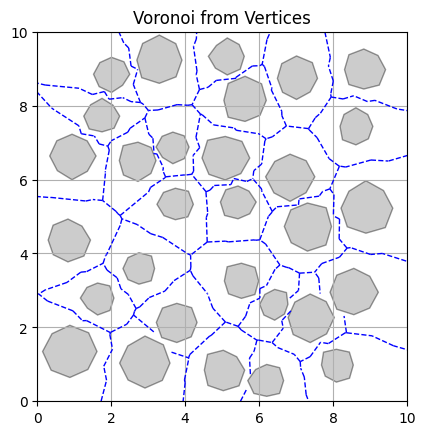

In [45]:
# Showing the new Voronoi diagram for the perturbed obstacles
perturbed = perturb_obstacles(obstacles, magnitude=0.05)
perturbed_points = extract_vertices(perturbed)
start = time.time()
vor = compute_voronoi(perturbed_points)
edges_pert = filter_edges(vor, perturbed)
total_time = time.time() - start
plot_environment(perturbed, edges_pert, title="Voronoi after Perturbation")
print(f"Time: {total_time:.4f} sec, Edges: {len(edges_pert)}")

# Plotting original to compare
plot_environment(obstacles, edges_vtx, title="Voronoi from Vertices")

### Running Experiments

This section we, will be testing how using Dijkstra's algorithm along with Voronoi diagrams to plan robotic motion can be affected by changing the number and complexity of obstacles, slightly perturbing obstacles, and comparing the efficiency of using obstacle vertices vs obstacle edges.

#### Setting up testing functions

In [10]:
def test_run(n_obstacles, complexity, use_vertices=True, perturb=False):
    "Main test function"

    # Setting up environment
    obstacles = generate_environment(n_obstacles, complexity)

    if perturb:
        perturbed = perturb_obstacles(obstacles, magnitude=0.05)
        perturbed_points = extract_vertices(perturbed)
        vor = compute_voronoi(perturbed_points)
        edges_pert = filter_edges(vor, perturbed)

    # Building Voronoi
    if use_vertices:
        points = extract_vertices(obstacles)
    else:
        points = sample_edges(obstacles, 5)

    vor = compute_voronoi(points)
    edges = filter_edges(vor, obstacles)

    # Build graph and run Dijkstra
    G = build_graph(edges)
    start = (1.0, 1.0)
    goal = (9.0, 9.0)

    path, dijkstra_time = run_dijkstra(G, start, goal)
    path_len = len(path) if path else 0

    return {
        "n_obstacles": n_obstacles,
        "complexity": complexity,
        "use_vertices":use_vertices,
        "perturb":perturb,
        "path_length":path_len,
        "dijkstra_time":dijkstra_time,
        "num_edges":len(edges)
    }

#### Experiment 1: Scaling with obstacle count and complexity

In [11]:
# Obstacle count
count_results = []
print("Average Dijkstra Time by Obstacle Count\n")
for n in range(10,51,4):
    n_results = []
    for _ in range(3): # averaging over 3 trials
        result = test_run(n, 6, use_vertices=True)
        n_results.append(result)
        count_results.append(result)
    # filtering out failed paths
    valid_times = [r["dijkstra_time"] for r in n_results if r["dijkstra_time"] is not None]
    avg_time = sum(valid_times) / len(valid_times) if valid_times else None

    print(f"Obstacles: {n:<2} | Trials: {len(valid_times)}/3 with paths | "
          f"Avg Time: {avg_time:.4f} s" if avg_time is not None else
          f"Obstacles: {n:<2} | No successful paths found.")

Average Dijkstra Time by Obstacle Count

Obstacles: 10 | Trials: 3/3 with paths | Avg Time: 0.0003 s
Obstacles: 14 | Trials: 3/3 with paths | Avg Time: 0.0010 s
Obstacles: 18 | Trials: 3/3 with paths | Avg Time: 0.0013 s
Obstacles: 22 | Trials: 3/3 with paths | Avg Time: 0.0012 s
Obstacles: 26 | Trials: 2/3 with paths | Avg Time: 0.0010 s
Obstacles: 30 | Trials: 1/3 with paths | Avg Time: 0.0020 s
Obstacles: 34 | Trials: 2/3 with paths | Avg Time: 0.0015 s
Obstacles: 38 | Trials: 3/3 with paths | Avg Time: 0.0015 s
Obstacles: 42 | Trials: 2/3 with paths | Avg Time: 0.0021 s
⚠️ Only placed 41 out of 46 obstacles after 500 attempts.
⚠️ Only placed 44 out of 46 obstacles after 500 attempts.
⚠️ Only placed 45 out of 46 obstacles after 500 attempts.
Obstacles: 46 | Trials: 3/3 with paths | Avg Time: 0.0017 s
⚠️ Only placed 48 out of 50 obstacles after 500 attempts.
⚠️ Only placed 44 out of 50 obstacles after 500 attempts.
⚠️ Only placed 45 out of 50 obstacles after 500 attempts.
Obstacles: 

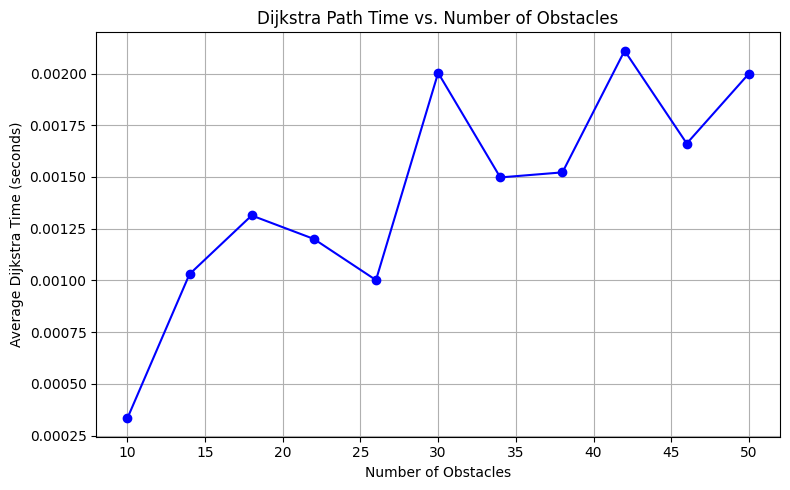

In [12]:
# Cleaning up data for plotting
filtered = [r for r in count_results if r["dijkstra_time"] is not None]
time_by_obstacle_count = defaultdict(list)
for r in filtered:
    n = r["n_obstacles"]
    time_by_obstacle_count[n].append(r["dijkstra_time"])

# Compute averages
obstacle_counts = sorted(time_by_obstacle_count.keys())
avg_times = [sum(times) / len(times) for times in [time_by_obstacle_count[n] for n in obstacle_counts]]


# Plotting
plt.figure(figsize=(8, 5))
plt.plot(obstacle_counts, avg_times, marker='o', label="Data", linestyle='-', color='blue')
plt.title("Dijkstra Path Time vs. Number of Obstacles")
plt.xlabel("Number of Obstacles")
plt.ylabel("Average Dijkstra Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

One issue that I have run into during this experiment is the possiblity that not every obstacle is placed due to the potential of overlapping when more and more obstacles are generated. We can see in the output that when reaching obstacle counts of around 46, there may be less obstacles placed which could lead to a lower runtime. Taking that into account we still observe an increase in runtime as obstacle count increases.

In [39]:
# Complexity

complexity_results = []
for c in [3, 6, 9, 12, 15, 18, 21, 24]:
    c_results = []
    for _ in range(3): # averaging over 3 trials
        result = test_run(20, c, use_vertices=True)
        c_results.append(result)
        complexity_results.append(result)
    # filtering out failed paths
    valid_times = [r["dijkstra_time"] for r in c_results if r["dijkstra_time"] is not None]
    avg_time = sum(valid_times) / len(valid_times) if valid_times else None

    print(f"Complexity: {c:<2} | Trials: {len(valid_times)}/3 with paths | "
          f"Avg Time: {avg_time:.4f} s" if avg_time is not None else
          f"Complexity: {c:<2} | No successful paths found.")

Complexity: 3  | Trials: 3/3 with paths | Avg Time: 0.0007 s
Complexity: 6  | Trials: 3/3 with paths | Avg Time: 0.0010 s
Complexity: 9  | Trials: 3/3 with paths | Avg Time: 0.0017 s
Complexity: 12 | Trials: 3/3 with paths | Avg Time: 0.0015 s
Complexity: 15 | Trials: 3/3 with paths | Avg Time: 0.0023 s
Complexity: 18 | Trials: 3/3 with paths | Avg Time: 0.0023 s
Complexity: 21 | Trials: 3/3 with paths | Avg Time: 0.0030 s
Complexity: 24 | Trials: 3/3 with paths | Avg Time: 0.0038 s


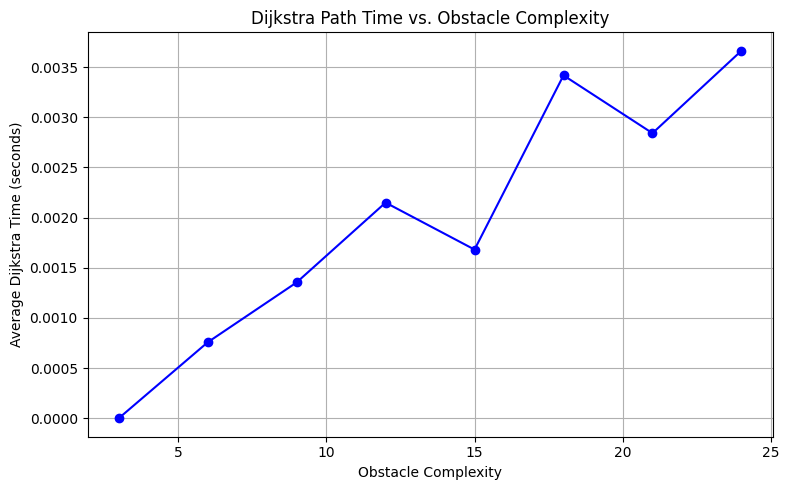

In [14]:
# Cleaning up data for plotting
filtered = [r for r in complexity_results if r["dijkstra_time"] is not None]
time_by_complexity = defaultdict(list)
for r in filtered:
    n = r["complexity"]
    time_by_complexity[n].append(r["dijkstra_time"])

# Compute averages
complexity = sorted(time_by_complexity.keys())
avg_times = [sum(times) / len(times) for times in [time_by_complexity[n] for n in complexity]]


# Plotting
plt.figure(figsize=(8, 5))
plt.plot(complexity, avg_times, marker='o', label="Data", linestyle='-', color='blue')
plt.title("Dijkstra Path Time vs. Obstacle Complexity")
plt.xlabel("Obstacle Complexity")
plt.ylabel("Average Dijkstra Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

Similarly to increasing obstacle count, increasing obstacle complexity can lead to there not being any possible path. To minimize this, I decreased the obstacle count to 20 randomly generated obstacles. We still observe that there are a few randomly generated environments that do not have any possible path. Once again, we see an increase in runtime as obstacle complexity increases.

#### Experiment 2: Sensitivity to small pertubations

In [47]:
pert_results = []
not_pert_results = []
for _ in range(10):
    pert_results.append(test_run(20, 6, use_vertices=True, perturb=True))
    not_pert_results.append(test_run(20, 6, use_vertices=True, perturb=False))

valid_times_pert = [r["dijkstra_time"] for r in pert_results if r["dijkstra_time"] is not None]
avg_time_pert = sum(valid_times_pert) / len(valid_times_pert) if valid_times_pert else None

valid_times_not_pert = [r["dijkstra_time"] for r in not_pert_results if r["dijkstra_time"] is not None]
avg_time_not_pert = sum(valid_times_not_pert) / len(valid_times_not_pert) if valid_times_not_pert else None

print(f"Perturbed Time: {avg_time_pert:.4f}, Not Perturbed Time: {avg_time_not_pert:.4f}")

Perturbed Time: 0.0011, Not Perturbed Time: 0.0010


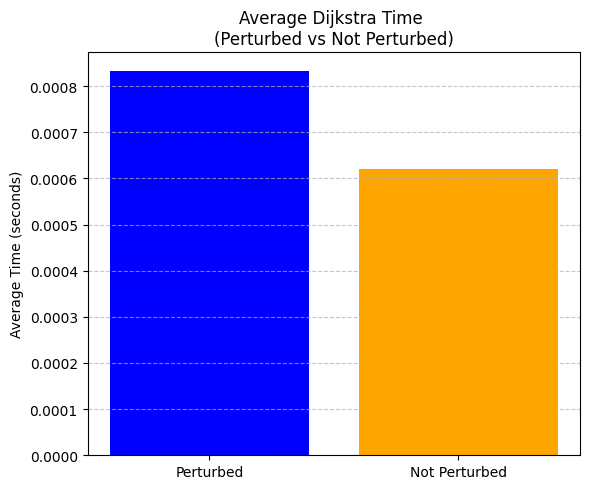

In [23]:
# Plotting
labels = ['Perturbed', 'Not Perturbed']
times = [avg_time_pert, avg_time_not_pert]
colors = ['blue', 'orange']

plt.figure(figsize=(6,5))
plt.bar(labels, times, color=colors)
plt.title('Average Dijkstra Time \n(Perturbed vs Not Perturbed)')
plt.ylabel('Average Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

After running this test a handful of times, we can see that the runtime for perturbed obstacles is on average higher than the runtime for the obstacles that are not perturbed. Once again this may be due to paths not existing or obstacles overlapping, so to minimize the number of times no path exists I have limited the test to 20 obstacles with consistent complexity.

#### Experiment 3: Vertices vs Sampled Edge Points

For this part of the experiment, we will be changing between using the vertices and edges of obstacles to generate the Voronoi diagrams.

When using the vertices, the sites in the Voronoi can be defined by: $S = \bigcup\limits_{i=1}^n\{v_{i1}, v_{i2}, \dots, v_{ik_i}\}$ where $v_{ij}$ are the vertices of the $i$-th obstacle.

When using the sampled edges, the sites in the Voronoi can be defined by: $S = \bigcup\limits_{i=1}^n\{p_{i1}, p_{i2}, \dots, p_{im_i}\}$ where $p_{ij}$ are the sampled points on the perimeter of obstacle $i$.

In [17]:
vertex_results=[]
# Vertex Times
for _ in range(5):
    vertex_results.append(test_run(20, 8, use_vertices=True))
valid_times_vertices = [r["dijkstra_time"] for r in vertex_results if r["dijkstra_time"] is not None]
avg_time_vertices = sum(valid_times_vertices) / len(valid_times_vertices) if valid_times_vertices else None

edge_results = []
# Edge Times
for _ in range(5):
    edge_results.append(test_run(20, 8, use_vertices=False))
valid_times_edges = [r["dijkstra_time"] for r in edge_results if r["dijkstra_time"] is not None]
avg_time_edges = sum(valid_times_edges) / len(valid_times_edges) if valid_times_edges else None

print(f"Vertex Time: {avg_time_vertices:.4f}, Edge Time: {avg_time_edges:.4f}")

Vertex Time: 0.0010, Edge Time: 0.0054


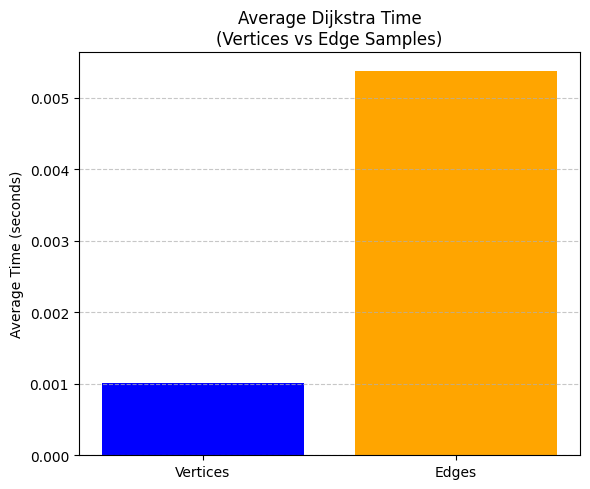

In [18]:
# Plotting
labels = ['Vertices', 'Edges']
times = [avg_time_vertices, avg_time_edges]
colors = ['blue', 'orange']

plt.figure(figsize=(6, 5))
plt.bar(labels, times, color=colors)
plt.title('Average Dijkstra Time\n(Vertices vs Edge Samples)')
plt.ylabel('Average Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We see that the runtime using sampled edges is higher than using the vertices of the obstacles. This is most likely due to there being more sampled edges than obstacle vertices.
Using sampled edges leads to a larger number of sites. When there are more sites, the corresponding Voronoi diagram becomes more complex. A more complex Voronoi diagram takes longer to generate and could take longer to find the shortest possible path due to there possibly being very similar paths that all need to be checked.

#### Next Steps

The next steps that I plan on taking on this project would be to build a bigger environment to try and dive deeper into the connection between runtime and obstacle count and complexity. I believe I will run into similar issues with overlapping obstacles once I reach high enough amounts of obstacles, but given more data I may be able to derive more accurate graphs to show the impact of obstacle count on runtime. In this project, the "robot" is represented by a point rather than a polygon. That is another change that could be made to see the effects of using Voronoi diagrams in planned robotic motion. After changing the representation of the robot, I could compare the use of Voronoi diagrams to the trapezodial maps traditionally used in planned robotic motion. I would run similar tests using identical environments to see which option is more efficient between the two.